In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

from util import array2mat

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/MBP/evaluate.npy', allow_pickle=True)

In [3]:
rna = rna[map_info.index]
rna = rna[rna.obs['cell_type'].isin(['ODC']),:]
rna.layers["counts"] = rna.X.copy()

In [4]:
_index = []
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
#     if eval_set[i]['cell_type'] in ['Endo']:
#         continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            _index.append(_rna[j].obs.index[0])
            
rna = rna[_index]
rna

View of AnnData object with n_obs × n_vars = 230 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

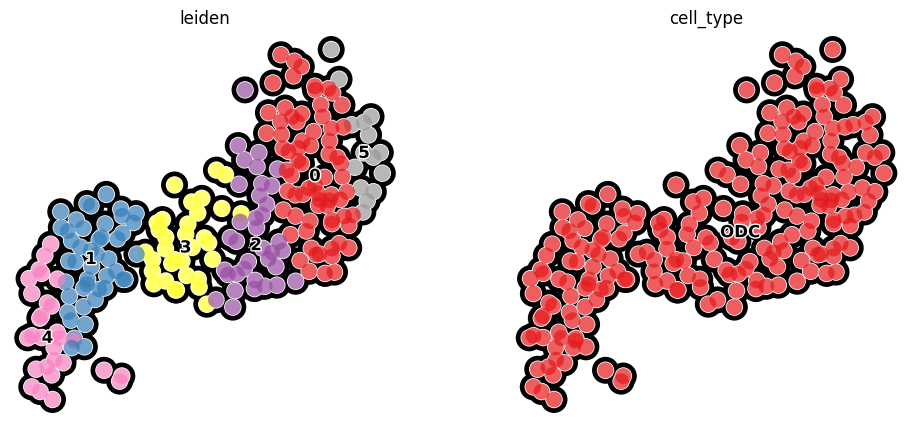

In [5]:
rna.X = rna.layers["counts"].copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
# sc.pp.normalize_total(rna)
# sc.pp.log1p(rna)
# sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.tl.leiden(rna)

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

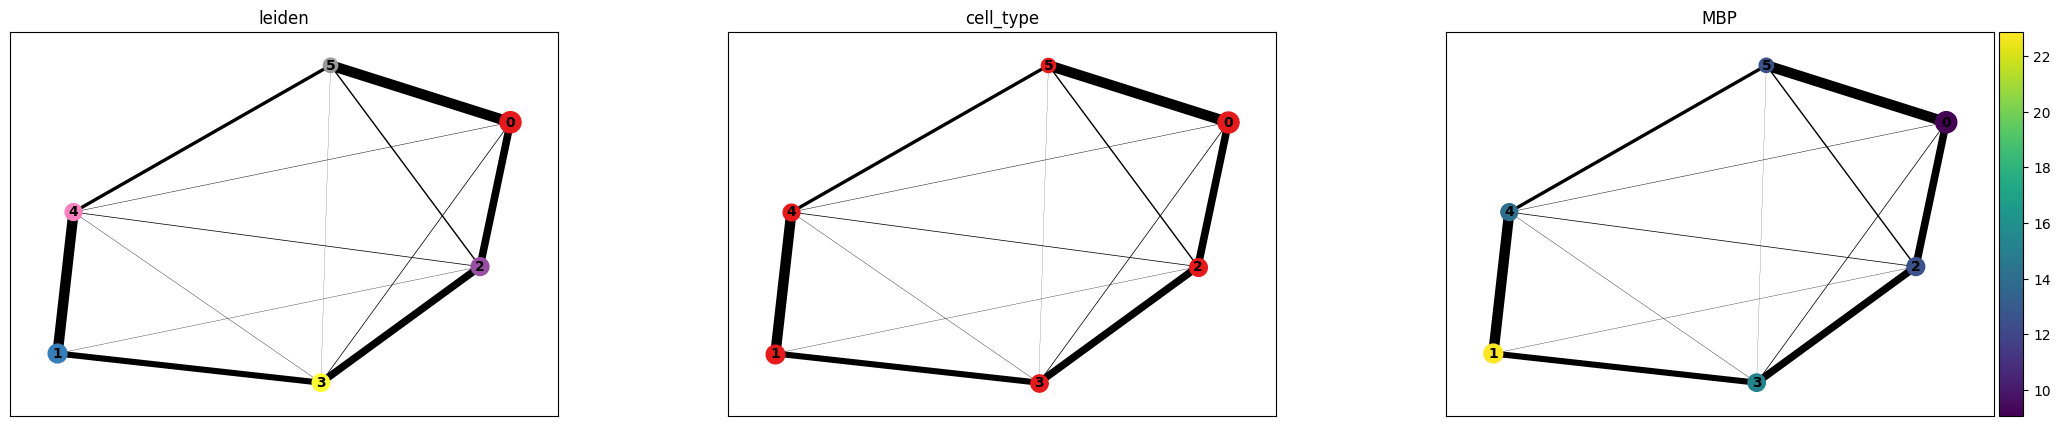

In [6]:
sc.tl.paga(rna, groups='leiden')
sc.pl.paga(rna, color=['leiden', 'cell_type', 'MBP'])

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


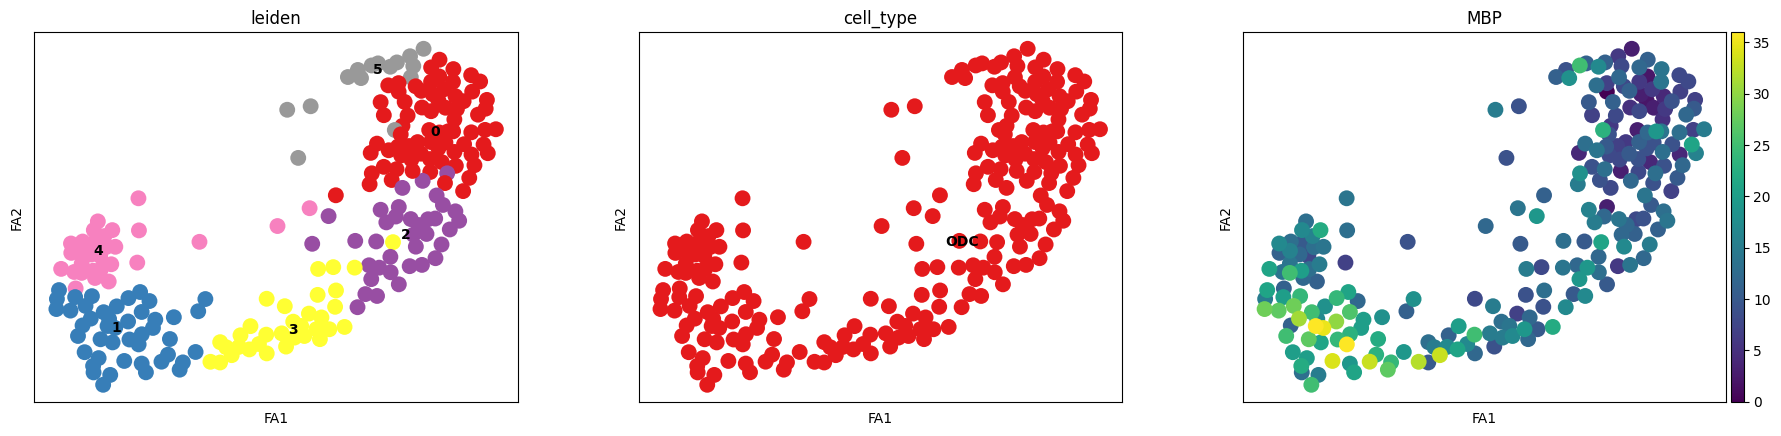

In [7]:
sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', 'MBP'], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


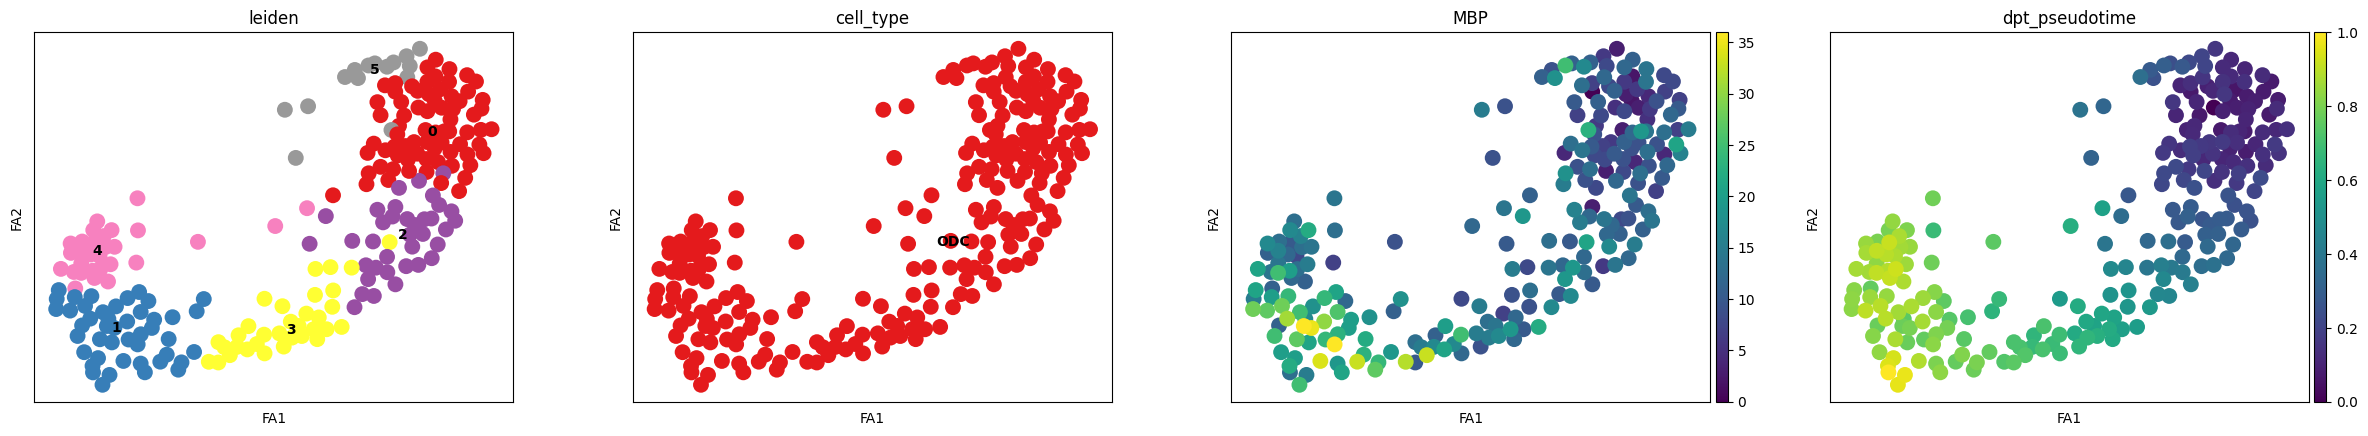

In [8]:
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']=='0')[0]
sc.tl.dpt(rna)

sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', 'MBP', 'dpt_pseudotime'], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


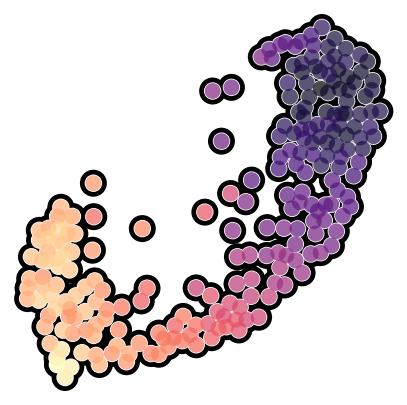

In [9]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.draw_graph(rna, color=['dpt_pseudotime'], cmap='magma',
                     add_outline=True, legend_loc=None, colorbar_loc=None, title='', frameon=False, return_fig=True)
    plt.savefig('/lmh_data/work/SEE/analyse/figure_file/pseudotime(MBP).pdf', format='pdf', bbox_inches='tight')
    plt.show()

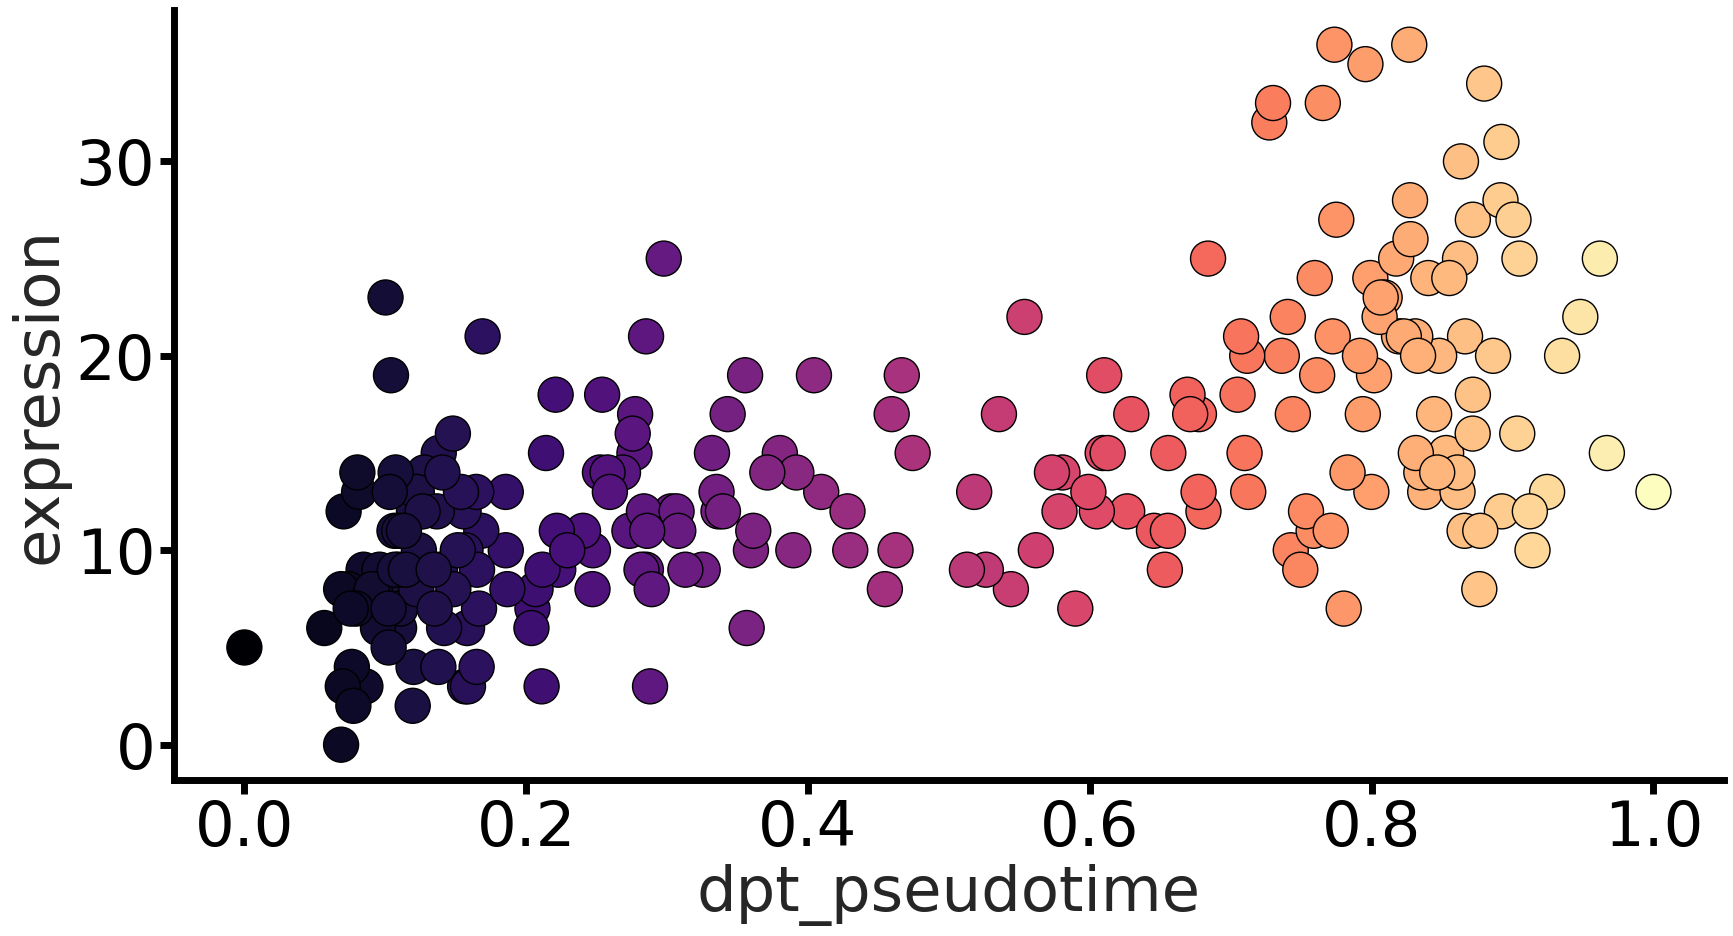

In [10]:
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

_x, _y = rna.obs['dpt_pseudotime'].values, rna[:, 'MBP'].layers["counts"].reshape(-1)
ax.scatter(_x, _y, edgecolors='black', s=(figure_size['large']*72./fig.dpi)**2, c=_x, cmap='magma')

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.xlabel('dpt_pseudotime', fontsize=figure_size['ultra'])
plt.ylabel('expression', fontsize=figure_size['ultra'])
plt.savefig('/lmh_data/work/SEE/analyse/figure_file/MBP expression(ODC).pdf', format='pdf', bbox_inches='tight')
plt.show()

In [11]:
scHiC = {}
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            scHiC[_rna[j].obs_names[0]] = preds[i]['predict']
            break
scHiC

{'CTAAGTGGTGTCCAAT-LKTX_190130_01_F01': array([ 5.43629050e-01,  6.17208183e-02,  4.40266589e-03,  1.30144134e-03,
         1.71857197e-02, -3.23946401e-02,  2.46876013e-02,  3.66253480e-02,
         3.25561501e-03,  6.14523888e-04,  7.65789673e-03, -9.30511672e-03,
         1.10772494e-02,  1.84511691e-02,  2.16991827e-03,  1.22456625e-02,
         7.33870268e-03,  6.52831733e-01,  5.84698021e-02,  9.62998904e-03,
         3.88363190e-03,  1.20091159e-02,  7.87926838e-04, -9.59225744e-03,
        -2.84041022e-03, -1.19923335e-02,  2.74950843e-02,  3.52792665e-02,
         9.24635679e-04,  1.14946701e-02,  2.19379365e-02,  4.33811918e-04,
         2.90955324e-03,  6.56288803e-01,  5.25901699e-03,  4.84072417e-03,
         2.87309214e-02,  4.31567021e-02,  3.49999182e-02, -6.35347515e-03,
        -1.53421462e-02, -1.05096325e-02,  2.87296623e-03, -1.00676008e-02,
         1.05391536e-02,  2.16928348e-02, -1.79328490e-02,  1.76904909e-02,
         4.74775970e-01,  5.36528192e-02, -1.0152

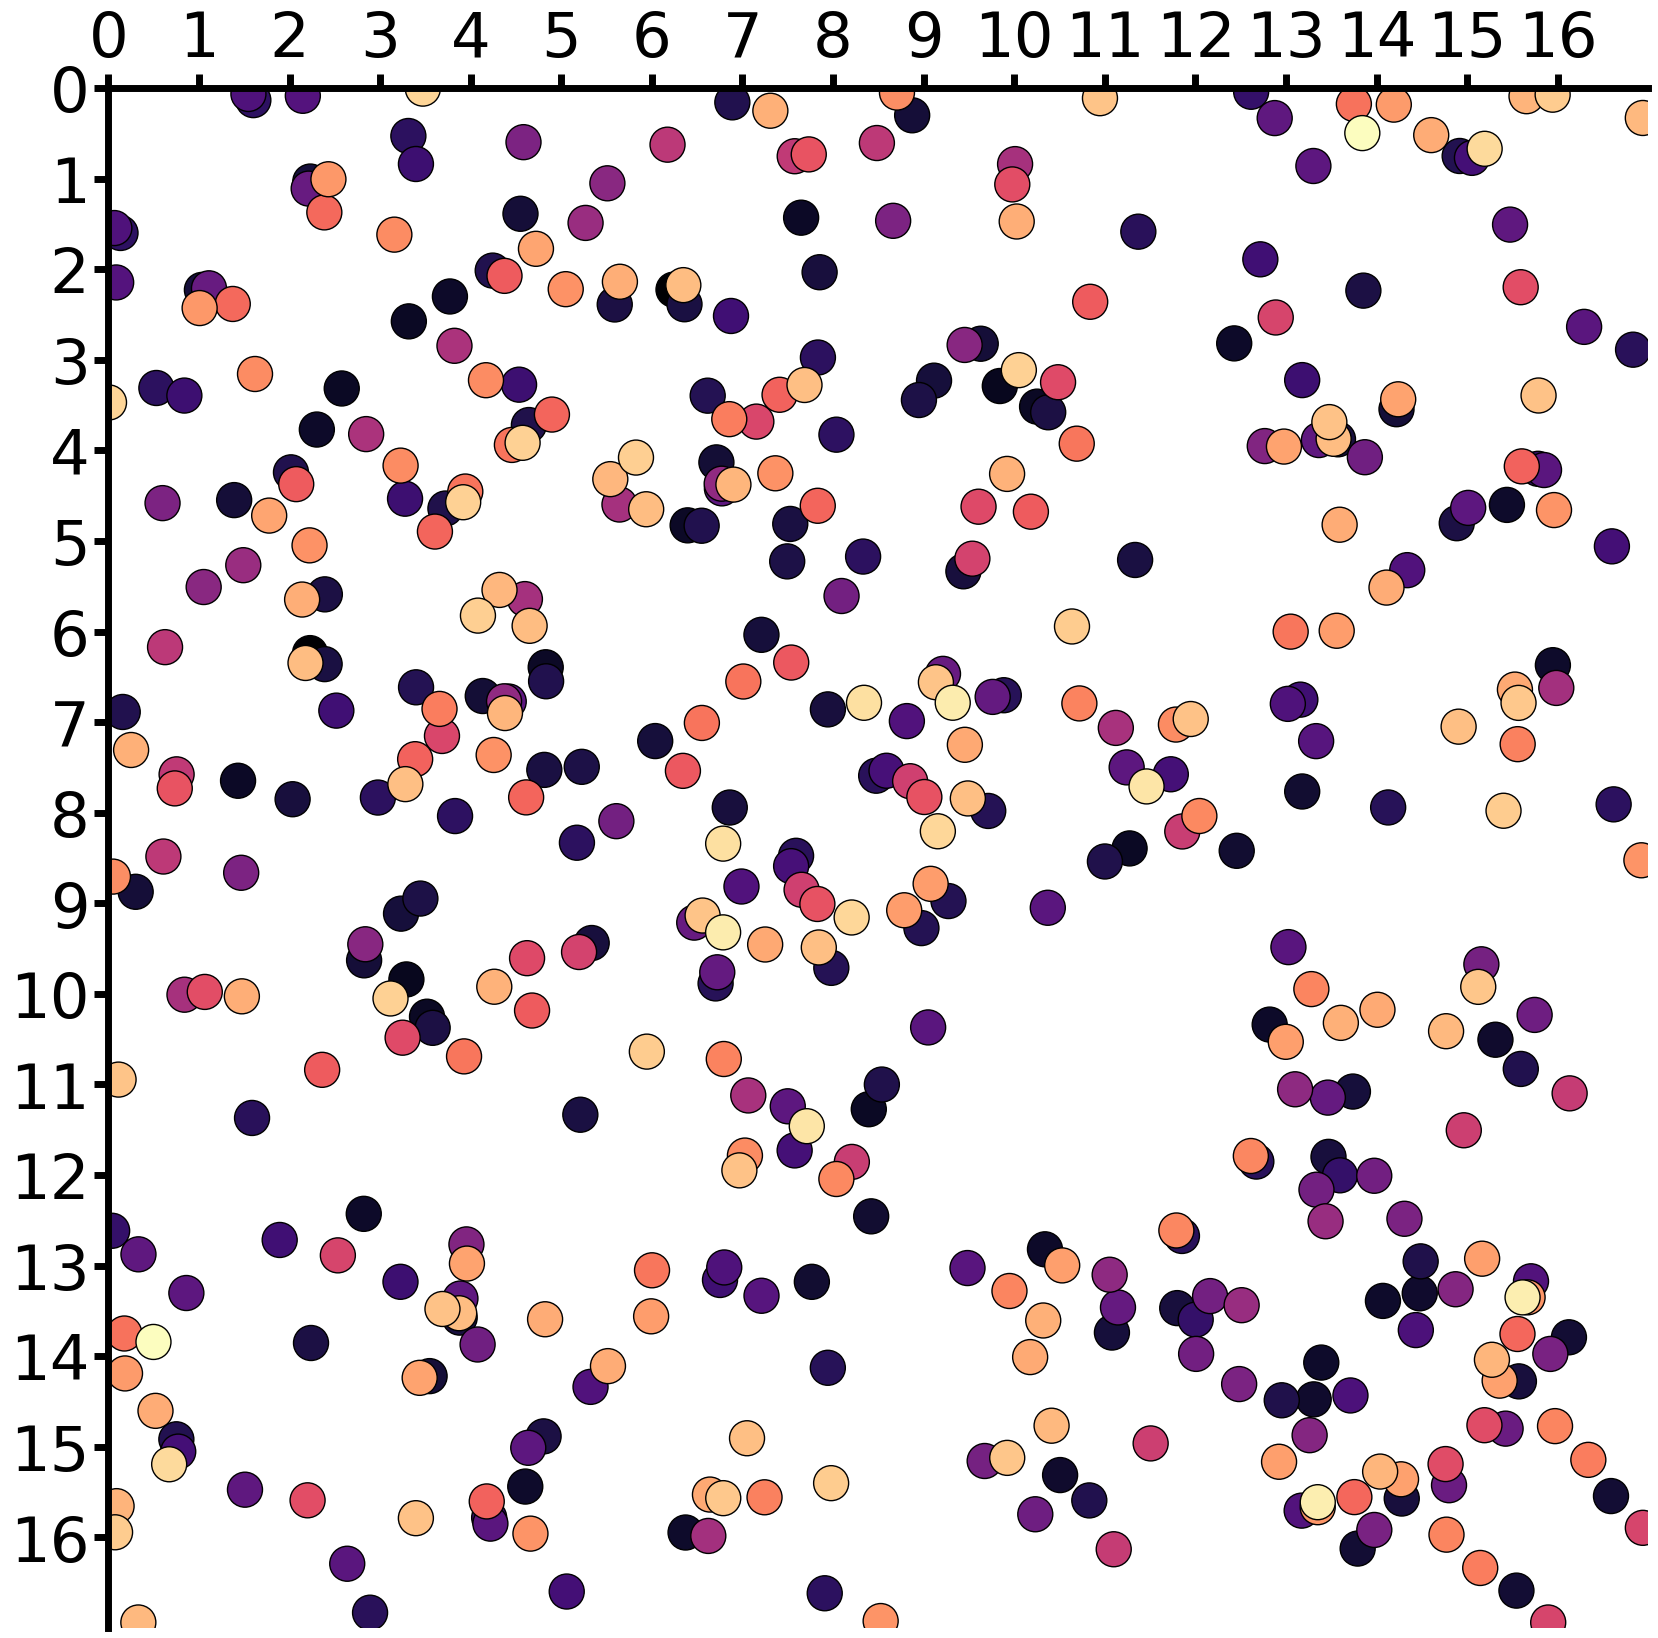

In [12]:
set_plt(figsize=(20, 20))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
set_Border(plt.gca())

_scatter_xs, _scatter_ys = [], []
_pseudotimes = []
for rna_name in rna.obs.sort_values(by='dpt_pseudotime').index:
    if rna_name not in scHiC.keys():
        continue
    _pseudotime = rna[rna_name].obs['dpt_pseudotime'].values[0]
    _hic = array2mat(scHiC[rna_name]).copy()
    _hic += abs(_hic.min())
    
    _where = np.where(np.ones(_hic.shape))
    _where = list(zip(_where[0], _where[1]))
    _test = np.zeros(len(_where), dtype=object)
    for i in range(len(_where)):
        _test[i] = _where[i]
    _where = _test
    _p = np.triu(_hic, 1).reshape(-1)
    _p /= _p.sum()

    _scatter_x, _scatter_y = [], []
    for (i, j) in np.random.choice(_where, 1, p=_p):
        _i, _j = random.random()+i, random.random()+j
        if i == j:
            _i, _j = max(_i, _j), min(_i, _j)
        _scatter_x.append(_i)
        _scatter_y.append(_j)

    _i, _j = _scatter_x.copy(), _scatter_y.copy()
    _scatter_x.extend(_j), _scatter_y.extend(_i)

    _scatter_xs.extend(_scatter_x), _scatter_ys.extend(_scatter_y)
    _pseudotimes.extend([_pseudotime]*len(_scatter_x))

plt.scatter(_scatter_xs, _scatter_ys, edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_pseudotimes, cmap='magma')

_len = array2mat(scHiC.get(next(iter(scHiC)))).shape[0]
plt.xticks([i for i in range(_len)])
plt.yticks([i for i in range(_len)])
plt.xlim((0, _len))
plt.ylim((0, _len))

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('none')
ax.spines['top'].set_linewidth(figure_size['very_small'])

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.savefig('/lmh_data/work/SEE/analyse/figure_file/MBP heatmap(ODC).pdf', format='pdf', bbox_inches='tight')
plt.show()

In [13]:
_partition = [
    rna.obs[rna.obs.dpt_pseudotime<=0.5],
    rna.obs[rna.obs.dpt_pseudotime>0.5]
]

pseudo_bulk_hic = []

for i in range(len(_partition)):
    _pseudo_bulk = None
    for rna_name in _partition[i].index:
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic

    pseudo_bulk_hic.append(_pseudo_bulk / len(_partition[i]))
pseudo_bulk_hic

[array([[0.5340697656, 0.0817062822, 0.0425261764, 0.046862079 ,
         0.0444905715, 0.0023774328, 0.0389254752, 0.0527585818,
         0.029545594 , 0.0280554804, 0.0384603626, 0.0279005058,
         0.0364701887, 0.0467855214, 0.0277095183, 0.0409376475,
         0.0371328744],
        [0.0817062822, 0.5760921911, 0.0862608489, 0.0473842337,
         0.0279144434, 0.0382683586, 0.02483363  , 0.0255290999,
         0.0274957544, 0.0132482986, 0.0469783103, 0.0556995922,
         0.027581482 , 0.0386539176, 0.0450981034, 0.0301303148,
         0.0328617961],
        [0.0425261764, 0.0862608489, 0.5852693903, 0.0317305647,
         0.0367778859, 0.0471121368, 0.0548276507, 0.0572883056,
         0.0294533496, 0.0243664834, 0.023325664 , 0.0396938675,
         0.023537123 , 0.0287450689, 0.0389068903, 0.0247174897,
         0.0350616637],
        [0.046862079 , 0.0473842337, 0.0317305647, 0.4810044053,
         0.0693442621, 0.0130902258, 0.0344871551, 0.0536398267,
         0.0291096

In [14]:
import os
import tempfile

def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(10, 10))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Greys', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

    if title:
        plt.savefig(
            '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()
    
def Calculate_chromatin_conformation(mat, out_dir):
    ftmp = tempfile.NamedTemporaryFile(delete=False)
    print(ftmp.name)
    with open(ftmp.name, 'w') as f:
        _strs = []
        for i in range(mat.shape[0]):
            _strs.append(','.join([str(j) for j in mat[i]])+'\n')
        f.writelines(_strs)

    os.makedirs(out_dir, exist_ok=True)
    with open('parameters.txt', 'w') as f:
        f.writelines([
            'NUM = 1\n', 'OUTPUT_FOLDER = {}\n'.format(out_dir), 'INPUT_FILE = {}\n'.format(ftmp.name),
            'VERBOSE = true\n', 'LEARNING_RATE = 1\n', 'MAX_ITERATION = 10000\n'
        ])

    os.system('java -jar /lmh_data/work/SEE/analyse/3DMax/3DMax.jar parameters.txt')

    os.remove(ftmp.name)
    os.remove('parameters.txt')

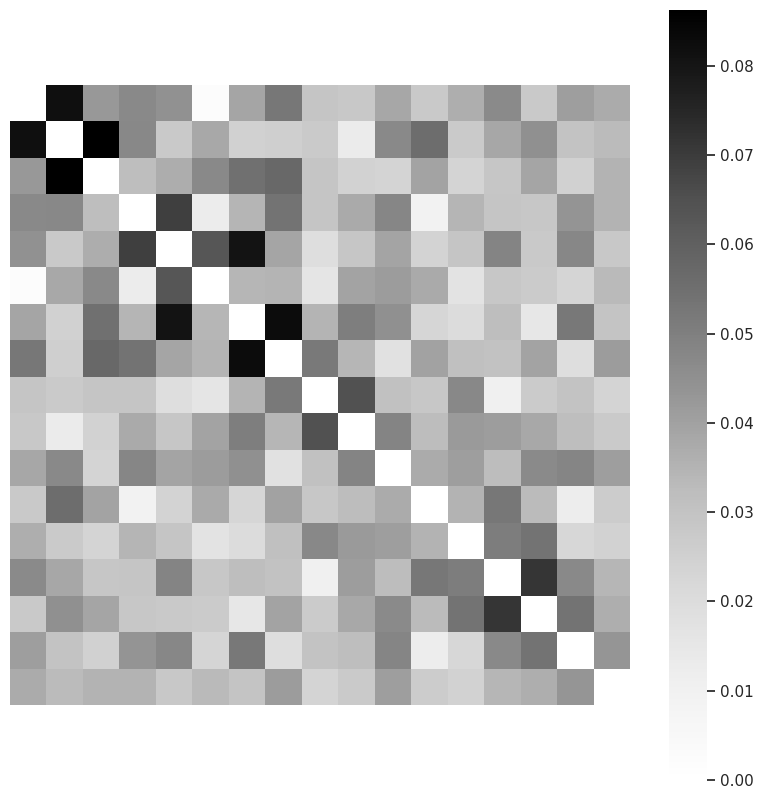

/tmp/tmp8wk81edn
3DMax for Genome Structure.
INSTRUCTION:
 (1) Input the file containing the parameters. 

Conversion to List Successful, New File = InputData_in_TupleFormat.txt
Number of points: 17
Number of constraints: 136
Max distance is: 13.02826995576696
Number of processors:1
Iteration 1, objective function:-60.34851, length of gradient 0.5721045
Iteration 2, objective function:-56.14091, length of gradient 0.6931058
Iteration 3, objective function:-52.08948, length of gradient 0.8108583
Iteration 4, objective function:-48.60290, length of gradient 0.8958805
Iteration 5, objective function:-46.13072, length of gradient 0.8592857
Iteration 6, objective function:-44.72801, length of gradient 0.6874087
Iteration 7, objective function:-43.94235, length of gradient 0.5075691
Iteration 8, objective function:-43.45866, length of gradient 0.3926208
Iteration 9, objective function:-43.14737, length of gradient 0.3138874
Iteration 10, objective function:-42.93979, length of gradient 0.255

Iteration 250, objective function:-41.46709, length of gradient 0.0154279
Iteration 251, objective function:-41.46631, length of gradient 0.0153478
Iteration 252, objective function:-41.46553, length of gradient 0.0152635
Iteration 253, objective function:-41.46477, length of gradient 0.0151752
Iteration 254, objective function:-41.46402, length of gradient 0.0150834
Iteration 255, objective function:-41.46327, length of gradient 0.0149882
Iteration 256, objective function:-41.46254, length of gradient 0.0148900
Iteration 257, objective function:-41.46182, length of gradient 0.0147890
Iteration 258, objective function:-41.46110, length of gradient 0.0146857
Iteration 259, objective function:-41.46040, length of gradient 0.0145803
Iteration 260, objective function:-41.45971, length of gradient 0.0144732
Iteration 261, objective function:-41.45903, length of gradient 0.0143646
Iteration 262, objective function:-41.45836, length of gradient 0.0142548
Iteration 263, objective function:-41.

Iteration 668, objective function:-41.17177, length of gradient 0.0101322
Iteration 669, objective function:-41.17143, length of gradient 0.0100602
Iteration 670, objective function:-41.17110, length of gradient 0.0099886
Iteration 671, objective function:-41.17077, length of gradient 0.0099176
Iteration 672, objective function:-41.17045, length of gradient 0.0098471
Iteration 673, objective function:-41.17013, length of gradient 0.0097771
Iteration 674, objective function:-41.16982, length of gradient 0.0097076
Iteration 675, objective function:-41.16951, length of gradient 0.0096385
Iteration 676, objective function:-41.16920, length of gradient 0.0095700
Iteration 677, objective function:-41.16890, length of gradient 0.0095018
Iteration 678, objective function:-41.16861, length of gradient 0.0094341
Iteration 679, objective function:-41.16832, length of gradient 0.0093668
Iteration 680, objective function:-41.16803, length of gradient 0.0093000
Iteration 681, objective function:-41.

Iteration 511, objective function:-41.29195, length of gradient 0.0051738
Iteration 512, objective function:-41.29185, length of gradient 0.0052168
Iteration 513, objective function:-41.29175, length of gradient 0.0052607
Iteration 514, objective function:-41.29164, length of gradient 0.0053053
Iteration 515, objective function:-41.29154, length of gradient 0.0053507
Iteration 516, objective function:-41.29143, length of gradient 0.0053970
Iteration 517, objective function:-41.29132, length of gradient 0.0054442
Iteration 518, objective function:-41.29121, length of gradient 0.0054923
Iteration 519, objective function:-41.29109, length of gradient 0.0055414
Iteration 520, objective function:-41.29098, length of gradient 0.0055916
Iteration 521, objective function:-41.29086, length of gradient 0.0056428
Iteration 522, objective function:-41.29074, length of gradient 0.0056952
Iteration 523, objective function:-41.29061, length of gradient 0.0057489
Iteration 524, objective function:-41.

Iteration 1085, objective function:-41.28523, length of gradient 0.0072768
Iteration 1086, objective function:-41.28505, length of gradient 0.0073698
Iteration 1087, objective function:-41.28486, length of gradient 0.0074634
Iteration 1088, objective function:-41.28467, length of gradient 0.0075575
Iteration 1089, objective function:-41.28447, length of gradient 0.0076523
Iteration 1090, objective function:-41.28427, length of gradient 0.0077475
Iteration 1091, objective function:-41.28406, length of gradient 0.0078432
Iteration 1092, objective function:-41.28385, length of gradient 0.0079393
Iteration 1093, objective function:-41.28364, length of gradient 0.0080357
Iteration 1094, objective function:-41.28342, length of gradient 0.0081324
Iteration 1095, objective function:-41.28319, length of gradient 0.0082293
Iteration 1096, objective function:-41.28296, length of gradient 0.0083264
Iteration 1097, objective function:-41.28272, length of gradient 0.0084235
Iteration 1098, objective

Iteration 8, objective function:-44.28091, length of gradient 0.3634970
Iteration 9, objective function:-43.97780, length of gradient 0.3129255
Iteration 10, objective function:-43.74513, length of gradient 0.2736243
Iteration 11, objective function:-43.55954, length of gradient 0.2417895
Iteration 12, objective function:-43.40477, length of gradient 0.2165973
Iteration 13, objective function:-43.27078, length of gradient 0.1973201
Iteration 14, objective function:-43.15271, length of gradient 0.1824378
Iteration 15, objective function:-43.04865, length of gradient 0.1701407
Iteration 16, objective function:-42.95739, length of gradient 0.1592473
Iteration 17, objective function:-42.87726, length of gradient 0.1494692
Iteration 18, objective function:-42.80616, length of gradient 0.1409404
Iteration 19, objective function:-42.74211, length of gradient 0.1336802
Iteration 20, objective function:-42.68360, length of gradient 0.1274610
Iteration 21, objective function:-42.62962, length of

Iteration 939, objective function:-39.94459, length of gradient 0.0021994
Iteration 940, objective function:-39.94458, length of gradient 0.0021709
Iteration 941, objective function:-39.94456, length of gradient 0.0021429
Iteration 942, objective function:-39.94455, length of gradient 0.0021152
Iteration 943, objective function:-39.94453, length of gradient 0.0020880
Iteration 944, objective function:-39.94452, length of gradient 0.0020612
Iteration 945, objective function:-39.94451, length of gradient 0.0020347
Iteration 946, objective function:-39.94450, length of gradient 0.0020087
Iteration 947, objective function:-39.94448, length of gradient 0.0019830
Iteration 948, objective function:-39.94447, length of gradient 0.0019577
Iteration 949, objective function:-39.94446, length of gradient 0.0019327
Iteration 950, objective function:-39.94445, length of gradient 0.0019081
Iteration 951, objective function:-39.94444, length of gradient 0.0018838
Iteration 952, objective function:-39.

Iteration 373, objective function:-39.59776, length of gradient 0.0207396
Iteration 374, objective function:-39.59640, length of gradient 0.0210489
Iteration 375, objective function:-39.59501, length of gradient 0.0213557
Iteration 376, objective function:-39.59358, length of gradient 0.0216585
Iteration 377, objective function:-39.59210, length of gradient 0.0219556
Iteration 378, objective function:-39.59058, length of gradient 0.0222454
Iteration 379, objective function:-39.58903, length of gradient 0.0225260
Iteration 380, objective function:-39.58744, length of gradient 0.0227955
Iteration 381, objective function:-39.58581, length of gradient 0.0230518
Iteration 382, objective function:-39.58414, length of gradient 0.0232931
Iteration 383, objective function:-39.58244, length of gradient 0.0235170
Iteration 384, objective function:-39.58071, length of gradient 0.0237215
Iteration 385, objective function:-39.57896, length of gradient 0.0239044
Iteration 386, objective function:-39.

Iteration 473, objective function:-39.68683, length of gradient 0.0082869
Iteration 474, objective function:-39.68660, length of gradient 0.0083728
Iteration 475, objective function:-39.68636, length of gradient 0.0084610
Iteration 476, objective function:-39.68612, length of gradient 0.0085517
Iteration 477, objective function:-39.68587, length of gradient 0.0086447
Iteration 478, objective function:-39.68562, length of gradient 0.0087401
Iteration 479, objective function:-39.68536, length of gradient 0.0088378
Iteration 480, objective function:-39.68509, length of gradient 0.0089378
Iteration 481, objective function:-39.68482, length of gradient 0.0090402
Iteration 482, objective function:-39.68454, length of gradient 0.0091449
Iteration 483, objective function:-39.68425, length of gradient 0.0092520
Iteration 484, objective function:-39.68396, length of gradient 0.0093614
Iteration 485, objective function:-39.68366, length of gradient 0.0094730
Iteration 486, objective function:-39.

Iteration 222, objective function:-40.13638, length of gradient 0.0021714
Iteration 223, objective function:-40.13637, length of gradient 0.0021195
Iteration 224, objective function:-40.13635, length of gradient 0.0020688
Iteration 225, objective function:-40.13634, length of gradient 0.0020193
Iteration 226, objective function:-40.13633, length of gradient 0.0019708
Iteration 227, objective function:-40.13632, length of gradient 0.0019235
Iteration 228, objective function:-40.13631, length of gradient 0.0018773
Iteration 229, objective function:-40.13630, length of gradient 0.0018321
Iteration 230, objective function:-40.13629, length of gradient 0.0017879
Iteration 231, objective function:-40.13628, length of gradient 0.0017448
Iteration 232, objective function:-40.13627, length of gradient 0.0017027
Iteration 233, objective function:-40.13626, length of gradient 0.0016615
Iteration 234, objective function:-40.13625, length of gradient 0.0016213
Iteration 235, objective function:-40.

Iteration 461, objective function:-42.96165, length of gradient 0.0016972
Iteration 462, objective function:-42.96165, length of gradient 0.0016839
Iteration 463, objective function:-42.96164, length of gradient 0.0016707
Iteration 464, objective function:-42.96163, length of gradient 0.0016575
Iteration 465, objective function:-42.96163, length of gradient 0.0016445
Iteration 466, objective function:-42.96162, length of gradient 0.0016315
Iteration 467, objective function:-42.96161, length of gradient 0.0016186
Iteration 468, objective function:-42.96160, length of gradient 0.0016057
Iteration 469, objective function:-42.96160, length of gradient 0.0015930
Iteration 470, objective function:-42.96159, length of gradient 0.0015803
Iteration 471, objective function:-42.96159, length of gradient 0.0015677
Iteration 472, objective function:-42.96158, length of gradient 0.0015552
Iteration 473, objective function:-42.96157, length of gradient 0.0015427
Iteration 474, objective function:-42.

Iteration 301, objective function:-46.68742, length of gradient 0.0007181
Iteration 302, objective function:-46.68742, length of gradient 0.0007012
Iteration 303, objective function:-46.68742, length of gradient 0.0006847
Iteration 304, objective function:-46.68742, length of gradient 0.0006686
Iteration 305, objective function:-46.68742, length of gradient 0.0006529
Iteration 306, objective function:-46.68742, length of gradient 0.0006376
Iteration 307, objective function:-46.68741, length of gradient 0.0006226
Iteration 308, objective function:-46.68741, length of gradient 0.0006079
Iteration 309, objective function:-46.68741, length of gradient 0.0005937
Iteration 310, objective function:-46.68741, length of gradient 0.0005797
Iteration 311, objective function:-46.68741, length of gradient 0.0005661
Iteration 312, objective function:-46.68741, length of gradient 0.0005528
Iteration 313, objective function:-46.68741, length of gradient 0.0005398
Iteration 314, objective function:-46.

Iteration 216, objective function:-51.13717, length of gradient 0.0073781
Iteration 217, objective function:-51.13686, length of gradient 0.0074448
Iteration 218, objective function:-51.13654, length of gradient 0.0075093
Iteration 219, objective function:-51.13622, length of gradient 0.0075710
Iteration 220, objective function:-51.13589, length of gradient 0.0076293
Iteration 221, objective function:-51.13556, length of gradient 0.0076839
Iteration 222, objective function:-51.13523, length of gradient 0.0077344
Iteration 223, objective function:-51.13489, length of gradient 0.0077805
Iteration 224, objective function:-51.13455, length of gradient 0.0078218
Iteration 225, objective function:-51.13420, length of gradient 0.0078583
Iteration 226, objective function:-51.13386, length of gradient 0.0078898
Iteration 227, objective function:-51.13351, length of gradient 0.0079162
Iteration 228, objective function:-51.13316, length of gradient 0.0079375
Iteration 229, objective function:-51.

Iteration 930, objective function:-50.95708, length of gradient 0.0043931
Iteration 931, objective function:-50.95697, length of gradient 0.0044082
Iteration 932, objective function:-50.95686, length of gradient 0.0044233
Iteration 933, objective function:-50.95675, length of gradient 0.0044384
Iteration 934, objective function:-50.95663, length of gradient 0.0044534
Iteration 935, objective function:-50.95652, length of gradient 0.0044684
Iteration 936, objective function:-50.95641, length of gradient 0.0044834
Iteration 937, objective function:-50.95629, length of gradient 0.0044984
Iteration 938, objective function:-50.95618, length of gradient 0.0045134
Iteration 939, objective function:-50.95606, length of gradient 0.0045284
Iteration 940, objective function:-50.95595, length of gradient 0.0045434
Iteration 941, objective function:-50.95583, length of gradient 0.0045585
Iteration 942, objective function:-50.95571, length of gradient 0.0045736
Iteration 943, objective function:-50.

Iteration 9, objective function:-56.94389, length of gradient 0.2781234
Iteration 10, objective function:-56.69734, length of gradient 0.2545268
Iteration 11, objective function:-56.48890, length of gradient 0.2326853
Iteration 12, objective function:-56.30944, length of gradient 0.2127612
Iteration 13, objective function:-56.15308, length of gradient 0.1946157
Iteration 14, objective function:-56.01727, length of gradient 0.1776831
Iteration 15, objective function:-55.90084, length of gradient 0.1615303
Iteration 16, objective function:-55.80204, length of gradient 0.1462757
Iteration 17, objective function:-55.71830, length of gradient 0.1323057
Iteration 18, objective function:-55.64689, length of gradient 0.1198815
Iteration 19, objective function:-55.58542, length of gradient 0.1090252
Iteration 20, objective function:-55.53207, length of gradient 0.0995849
Iteration 21, objective function:-55.48546, length of gradient 0.0913367
Iteration 22, objective function:-55.44460, length o

Iteration 197, objective function:-59.32249, length of gradient 0.0068273
Iteration 198, objective function:-59.32219, length of gradient 0.0067561
Iteration 199, objective function:-59.32189, length of gradient 0.0066857
Iteration 200, objective function:-59.32160, length of gradient 0.0066160
Iteration 201, objective function:-59.32131, length of gradient 0.0065469
Iteration 202, objective function:-59.32103, length of gradient 0.0064786
Iteration 203, objective function:-59.32076, length of gradient 0.0064109
Iteration 204, objective function:-59.32049, length of gradient 0.0063439
Iteration 205, objective function:-59.32022, length of gradient 0.0062775
Iteration 206, objective function:-59.31996, length of gradient 0.0062117
Iteration 207, objective function:-59.31971, length of gradient 0.0061466
Iteration 208, objective function:-59.31946, length of gradient 0.0060821
Iteration 209, objective function:-59.31922, length of gradient 0.0060182
Iteration 210, objective function:-59.

Iteration 439, objective function:-63.54317, length of gradient 0.0011548
Iteration 440, objective function:-63.54316, length of gradient 0.0011524
Iteration 441, objective function:-63.54314, length of gradient 0.0011501
Iteration 442, objective function:-63.54313, length of gradient 0.0011478
Iteration 443, objective function:-63.54312, length of gradient 0.0011456
Iteration 444, objective function:-63.54310, length of gradient 0.0011434
Iteration 445, objective function:-63.54309, length of gradient 0.0011413
Iteration 446, objective function:-63.54308, length of gradient 0.0011392
Iteration 447, objective function:-63.54306, length of gradient 0.0011373
Iteration 448, objective function:-63.54305, length of gradient 0.0011353
Iteration 449, objective function:-63.54304, length of gradient 0.0011335
Iteration 450, objective function:-63.54302, length of gradient 0.0011317
Iteration 451, objective function:-63.54301, length of gradient 0.0011300
Iteration 452, objective function:-63.

Iteration 190, objective function:-67.50248, length of gradient 0.0015562
Iteration 191, objective function:-67.50245, length of gradient 0.0015415
Iteration 192, objective function:-67.50242, length of gradient 0.0015269
Iteration 193, objective function:-67.50239, length of gradient 0.0015125
Iteration 194, objective function:-67.50237, length of gradient 0.0014983
Iteration 195, objective function:-67.50234, length of gradient 0.0014842
Iteration 196, objective function:-67.50232, length of gradient 0.0014703
Iteration 197, objective function:-67.50229, length of gradient 0.0014565
Iteration 198, objective function:-67.50227, length of gradient 0.0014429
Iteration 199, objective function:-67.50224, length of gradient 0.0014294
Iteration 200, objective function:-67.50222, length of gradient 0.0014161
Iteration 201, objective function:-67.50219, length of gradient 0.0014029
Iteration 202, objective function:-67.50217, length of gradient 0.0013898
Iteration 203, objective function:-67.

Iteration 118, objective function:-71.38653, length of gradient 0.0023705
Iteration 119, objective function:-71.38643, length of gradient 0.0023482
Iteration 120, objective function:-71.38632, length of gradient 0.0023279
Iteration 121, objective function:-71.38622, length of gradient 0.0023096
Iteration 122, objective function:-71.38612, length of gradient 0.0022931
Iteration 123, objective function:-71.38602, length of gradient 0.0022783
Iteration 124, objective function:-71.38591, length of gradient 0.0022651
Iteration 125, objective function:-71.38581, length of gradient 0.0022535
Iteration 126, objective function:-71.38571, length of gradient 0.0022433
Iteration 127, objective function:-71.38560, length of gradient 0.0022345
Iteration 128, objective function:-71.38550, length of gradient 0.0022270
Iteration 129, objective function:-71.38540, length of gradient 0.0022206
Iteration 130, objective function:-71.38529, length of gradient 0.0022153
Iteration 131, objective function:-71.

Iteration 99, objective function:-78.44262, length of gradient 0.0095573
Iteration 100, objective function:-78.44188, length of gradient 0.0093348
Iteration 101, objective function:-78.44117, length of gradient 0.0091179
Iteration 102, objective function:-78.44048, length of gradient 0.0089063
Iteration 103, objective function:-78.43983, length of gradient 0.0087000
Iteration 104, objective function:-78.43920, length of gradient 0.0084988
Iteration 105, objective function:-78.43859, length of gradient 0.0083026
Iteration 106, objective function:-78.43801, length of gradient 0.0081113
Iteration 107, objective function:-78.43746, length of gradient 0.0079246
Iteration 108, objective function:-78.43692, length of gradient 0.0077425
Iteration 109, objective function:-78.43641, length of gradient 0.0075647
Iteration 110, objective function:-78.43592, length of gradient 0.0073911
Iteration 111, objective function:-78.43544, length of gradient 0.0072216
Iteration 112, objective function:-78.4

Iteration 248, objective function:-81.65900, length of gradient 0.0010215
Iteration 249, objective function:-81.65898, length of gradient 0.0010069
Iteration 250, objective function:-81.65895, length of gradient 0.0009926
Iteration 251, objective function:-81.65893, length of gradient 0.0009787
Iteration 252, objective function:-81.65890, length of gradient 0.0009649
Iteration 253, objective function:-81.65888, length of gradient 0.0009515
Iteration 254, objective function:-81.65886, length of gradient 0.0009383
Iteration 255, objective function:-81.65883, length of gradient 0.0009254
Iteration 256, objective function:-81.65881, length of gradient 0.0009127
Iteration 257, objective function:-81.65879, length of gradient 0.0009003
Iteration 258, objective function:-81.65877, length of gradient 0.0008881
Iteration 259, objective function:-81.65874, length of gradient 0.0008762
Iteration 260, objective function:-81.65872, length of gradient 0.0008645
Iteration 261, objective function:-81.

Iteration 59, objective function:-87.66587, length of gradient 0.0255331
Iteration 60, objective function:-87.66034, length of gradient 0.0252435
Iteration 61, objective function:-87.65495, length of gradient 0.0249577
Iteration 62, objective function:-87.64970, length of gradient 0.0246755
Iteration 63, objective function:-87.64458, length of gradient 0.0243970
Iteration 64, objective function:-87.63958, length of gradient 0.0241220
Iteration 65, objective function:-87.63471, length of gradient 0.0238505
Iteration 66, objective function:-87.62996, length of gradient 0.0235824
Iteration 67, objective function:-87.62532, length of gradient 0.0233177
Iteration 68, objective function:-87.62080, length of gradient 0.0230563
Iteration 69, objective function:-87.61639, length of gradient 0.0227981
Iteration 70, objective function:-87.61208, length of gradient 0.0225432
Iteration 71, objective function:-87.60788, length of gradient 0.0222913
Iteration 72, objective function:-87.60378, length 

Iteration 278, objective function:-89.94760, length of gradient 0.0034897
Iteration 279, objective function:-89.94750, length of gradient 0.0034596
Iteration 280, objective function:-89.94741, length of gradient 0.0034299
Iteration 281, objective function:-89.94732, length of gradient 0.0034003
Iteration 282, objective function:-89.94723, length of gradient 0.0033711
Iteration 283, objective function:-89.94715, length of gradient 0.0033420
Iteration 284, objective function:-89.94706, length of gradient 0.0033133
Iteration 285, objective function:-89.94698, length of gradient 0.0032847
Iteration 286, objective function:-89.94689, length of gradient 0.0032565
Iteration 287, objective function:-89.94681, length of gradient 0.0032284
Iteration 288, objective function:-89.94673, length of gradient 0.0032006
Iteration 289, objective function:-89.94665, length of gradient 0.0031731
Iteration 290, objective function:-89.94658, length of gradient 0.0031458
Iteration 291, objective function:-89.

Iteration 400, objective function:-92.20677, length of gradient 0.0019880
Iteration 401, objective function:-92.20674, length of gradient 0.0019742
Iteration 402, objective function:-92.20670, length of gradient 0.0019604
Iteration 403, objective function:-92.20667, length of gradient 0.0019468
Iteration 404, objective function:-92.20664, length of gradient 0.0019333
Iteration 405, objective function:-92.20660, length of gradient 0.0019198
Iteration 406, objective function:-92.20657, length of gradient 0.0019065
Iteration 407, objective function:-92.20654, length of gradient 0.0018933
Iteration 408, objective function:-92.20650, length of gradient 0.0018801
Iteration 409, objective function:-92.20647, length of gradient 0.0018670
Iteration 410, objective function:-92.20644, length of gradient 0.0018541
Iteration 411, objective function:-92.20641, length of gradient 0.0018412
Iteration 412, objective function:-92.20638, length of gradient 0.0018284
Iteration 413, objective function:-92.

Iteration 45, objective function:-42.04047, length of gradient 0.1445656
Iteration 46, objective function:-41.98422, length of gradient 0.1394015
Iteration 47, objective function:-41.93215, length of gradient 0.1342686
Iteration 48, objective function:-41.88376, length of gradient 0.1294027
Iteration 49, objective function:-41.83857, length of gradient 0.1249118
Iteration 50, objective function:-41.79618, length of gradient 0.1207989
Iteration 51, objective function:-41.75625, length of gradient 0.1170064
Iteration 52, objective function:-41.71855, length of gradient 0.1134607
Iteration 53, objective function:-41.68286, length of gradient 0.1101060
Iteration 54, objective function:-41.64898, length of gradient 0.1069235
Iteration 55, objective function:-41.61671, length of gradient 0.1039366
Iteration 56, objective function:-41.58580, length of gradient 0.1012042
Iteration 57, objective function:-41.55600, length of gradient 0.0988060
Iteration 58, objective function:-41.52702, length 

In [15]:
_draw(pseudo_bulk_hic[0], ignore_diag=True)
Calculate_chromatin_conformation(pseudo_bulk_hic[0]*1000, 'Early')

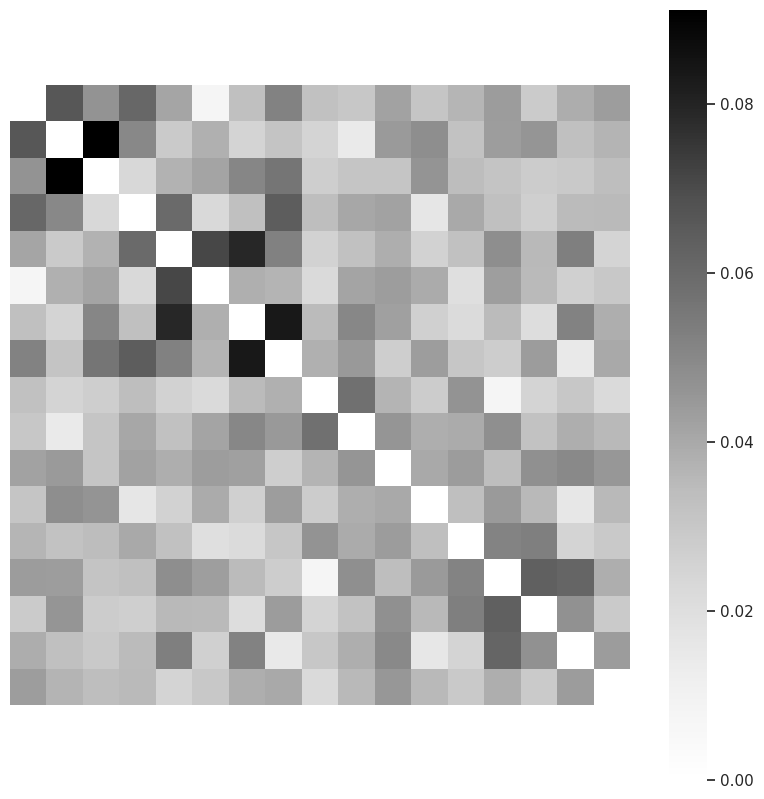

/tmp/tmpu0wu9z_i
3DMax for Genome Structure.
INSTRUCTION:
 (1) Input the file containing the parameters. 

Conversion to List Successful, New File = InputData_in_TupleFormat.txt
Number of points: 17
Number of constraints: 136
Max distance is: 11.683925849403597
Number of processors:1
Iteration 1, objective function:-60.50487, length of gradient 0.5684331
Iteration 2, objective function:-56.43494, length of gradient 0.6760521
Iteration 3, objective function:-52.47913, length of gradient 0.7927310
Iteration 4, objective function:-49.14032, length of gradient 0.8748101
Iteration 5, objective function:-46.73731, length of gradient 0.8369865
Iteration 6, objective function:-45.21878, length of gradient 0.6936940
Iteration 7, objective function:-44.27549, length of gradient 0.5436413
Iteration 8, objective function:-43.66134, length of gradient 0.4377157
Iteration 9, objective function:-43.25660, length of gradient 0.3577569
Iteration 10, objective function:-42.98609, length of gradient 0.29

Iteration 341, objective function:-41.67858, length of gradient 0.0082175
Iteration 342, objective function:-41.67836, length of gradient 0.0082496
Iteration 343, objective function:-41.67813, length of gradient 0.0082818
Iteration 344, objective function:-41.67791, length of gradient 0.0083142
Iteration 345, objective function:-41.67768, length of gradient 0.0083469
Iteration 346, objective function:-41.67746, length of gradient 0.0083796
Iteration 347, objective function:-41.67723, length of gradient 0.0084125
Iteration 348, objective function:-41.67700, length of gradient 0.0084455
Iteration 349, objective function:-41.67677, length of gradient 0.0084786
Iteration 350, objective function:-41.67653, length of gradient 0.0085118
Iteration 351, objective function:-41.67630, length of gradient 0.0085451
Iteration 352, objective function:-41.67606, length of gradient 0.0085783
Iteration 353, objective function:-41.67582, length of gradient 0.0086116
Iteration 354, objective function:-41.

Iteration 833, objective function:-41.50287, length of gradient 0.0013994
Iteration 834, objective function:-41.50287, length of gradient 0.0013742
Iteration 835, objective function:-41.50286, length of gradient 0.0013495
Iteration 836, objective function:-41.50286, length of gradient 0.0013253
Iteration 837, objective function:-41.50285, length of gradient 0.0013016
Iteration 838, objective function:-41.50284, length of gradient 0.0012784
Iteration 839, objective function:-41.50284, length of gradient 0.0012556
Iteration 840, objective function:-41.50283, length of gradient 0.0012333
Iteration 841, objective function:-41.50283, length of gradient 0.0012115
Iteration 842, objective function:-41.50283, length of gradient 0.0011901
Iteration 843, objective function:-41.50282, length of gradient 0.0011691
Iteration 844, objective function:-41.50282, length of gradient 0.0011486
Iteration 845, objective function:-41.50281, length of gradient 0.0011285
Iteration 846, objective function:-41.

Iteration 1358, objective function:-41.32749, length of gradient 0.0032850
Iteration 1359, objective function:-41.32746, length of gradient 0.0032931
Iteration 1360, objective function:-41.32742, length of gradient 0.0033013
Iteration 1361, objective function:-41.32738, length of gradient 0.0033094
Iteration 1362, objective function:-41.32734, length of gradient 0.0033176
Iteration 1363, objective function:-41.32730, length of gradient 0.0033258
Iteration 1364, objective function:-41.32726, length of gradient 0.0033340
Iteration 1365, objective function:-41.32722, length of gradient 0.0033421
Iteration 1366, objective function:-41.32718, length of gradient 0.0033503
Iteration 1367, objective function:-41.32714, length of gradient 0.0033585
Iteration 1368, objective function:-41.32710, length of gradient 0.0033667
Iteration 1369, objective function:-41.32706, length of gradient 0.0033749
Iteration 1370, objective function:-41.32702, length of gradient 0.0033831
Iteration 1371, objective

Iteration 213, objective function:-40.78724, length of gradient 0.0472412
Iteration 214, objective function:-40.78044, length of gradient 0.0463885
Iteration 215, objective function:-40.77388, length of gradient 0.0454993
Iteration 216, objective function:-40.76757, length of gradient 0.0445792
Iteration 217, objective function:-40.76150, length of gradient 0.0436343
Iteration 218, objective function:-40.75568, length of gradient 0.0426716
Iteration 219, objective function:-40.75010, length of gradient 0.0416987
Iteration 220, objective function:-40.74476, length of gradient 0.0407235
Iteration 221, objective function:-40.73966, length of gradient 0.0397543
Iteration 222, objective function:-40.73478, length of gradient 0.0387994
Iteration 223, objective function:-40.73011, length of gradient 0.0378667
Iteration 224, objective function:-40.72564, length of gradient 0.0369638
Iteration 225, objective function:-40.72137, length of gradient 0.0360975
Iteration 226, objective function:-40.

Iteration 91, objective function:-41.39750, length of gradient 0.0641702
Iteration 92, objective function:-41.38519, length of gradient 0.0629139
Iteration 93, objective function:-41.37357, length of gradient 0.0612737
Iteration 94, objective function:-41.36269, length of gradient 0.0593622
Iteration 95, objective function:-41.35255, length of gradient 0.0572945
Iteration 96, objective function:-41.34311, length of gradient 0.0551769
Iteration 97, objective function:-41.33433, length of gradient 0.0530993
Iteration 98, objective function:-41.32612, length of gradient 0.0511319
Iteration 99, objective function:-41.31842, length of gradient 0.0493245
Iteration 100, objective function:-41.31113, length of gradient 0.0477084
Iteration 101, objective function:-41.30420, length of gradient 0.0462991
Iteration 102, objective function:-41.29756, length of gradient 0.0450997
Iteration 103, objective function:-41.29114, length of gradient 0.0441041
Iteration 104, objective function:-41.28489, le

Iteration 145, objective function:-40.10774, length of gradient 0.0396442
Iteration 146, objective function:-40.10218, length of gradient 0.0409304
Iteration 147, objective function:-40.09623, length of gradient 0.0423407
Iteration 148, objective function:-40.08981, length of gradient 0.0438706
Iteration 149, objective function:-40.08289, length of gradient 0.0455102
Iteration 150, objective function:-40.07542, length of gradient 0.0472410
Iteration 151, objective function:-40.06734, length of gradient 0.0490350
Iteration 152, objective function:-40.05863, length of gradient 0.0508523
Iteration 153, objective function:-40.04927, length of gradient 0.0526403
Iteration 154, objective function:-40.03929, length of gradient 0.0543343
Iteration 155, objective function:-40.02873, length of gradient 0.0558603
Iteration 156, objective function:-40.01767, length of gradient 0.0571412
Iteration 157, objective function:-40.00624, length of gradient 0.0581055
Iteration 158, objective function:-39.

Iteration 999, objective function:-39.40100, length of gradient 0.0006059
Iteration 1000, objective function:-39.40100, length of gradient 0.0005979
Iteration 1001, objective function:-39.40100, length of gradient 0.0005901
Iteration 1002, objective function:-39.40099, length of gradient 0.0005823
Iteration 1003, objective function:-39.40099, length of gradient 0.0005748
Iteration 1004, objective function:-39.40099, length of gradient 0.0005673
Iteration 1005, objective function:-39.40099, length of gradient 0.0005600
Iteration 1006, objective function:-39.40099, length of gradient 0.0005528
Iteration 1007, objective function:-39.40099, length of gradient 0.0005457
Iteration 1008, objective function:-39.40099, length of gradient 0.0005388
Iteration 1009, objective function:-39.40099, length of gradient 0.0005319
Iteration 1010, objective function:-39.40099, length of gradient 0.0005252
Iteration 1011, objective function:-39.40099, length of gradient 0.0005186
Iteration 1012, objective 

Iteration 1298, objective function:-39.57668, length of gradient 0.0229765
Iteration 1299, objective function:-39.57492, length of gradient 0.0226131
Iteration 1300, objective function:-39.57320, length of gradient 0.0222554
Iteration 1301, objective function:-39.57154, length of gradient 0.0219025
Iteration 1302, objective function:-39.56993, length of gradient 0.0215540
Iteration 1303, objective function:-39.56837, length of gradient 0.0212099
Iteration 1304, objective function:-39.56686, length of gradient 0.0208704
Iteration 1305, objective function:-39.56540, length of gradient 0.0205360
Iteration 1306, objective function:-39.56398, length of gradient 0.0202074
Iteration 1307, objective function:-39.56261, length of gradient 0.0198856
Iteration 1308, objective function:-39.56128, length of gradient 0.0195715
Iteration 1309, objective function:-39.55999, length of gradient 0.0192661
Iteration 1310, objective function:-39.55874, length of gradient 0.0189707
Iteration 1311, objective

Iteration 2577, objective function:-39.13134, length of gradient 0.0004244
Iteration 2578, objective function:-39.13134, length of gradient 0.0004170
Iteration 2579, objective function:-39.13134, length of gradient 0.0004099
Iteration 2580, objective function:-39.13134, length of gradient 0.0004029
Iteration 2581, objective function:-39.13134, length of gradient 0.0003961
AVG RMSE: 98.41899660326196
AVG Spearman correlation IFs vs. Reconstructed Dist: -0.6382813310930752
AVG Spearman correlation WishDist vs. Reconstructed Dist: 0.6382813310930754
AVG Pearson correlation WishDist vs. Reconstructed Dist: 0.632114481821649
Number of points: 17
Number of constraints: 136
Max distance is: 18.469056399857006
Number of processors:1
Iteration 1, objective function:-60.56788, length of gradient 0.5561937
Iteration 2, objective function:-56.40952, length of gradient 0.6765695
Iteration 3, objective function:-52.52978, length of gradient 0.7873501
Iteration 4, objective function:-49.40161, length

Iteration 24, objective function:-42.94363, length of gradient 0.2066347
Iteration 25, objective function:-42.80031, length of gradient 0.2045894
Iteration 26, objective function:-42.66085, length of gradient 0.2030922
Iteration 27, objective function:-42.52359, length of gradient 0.2022689
Iteration 28, objective function:-42.38713, length of gradient 0.2020760
Iteration 29, objective function:-42.25062, length of gradient 0.2022973
Iteration 30, objective function:-42.11399, length of gradient 0.2025586
Iteration 31, objective function:-41.97808, length of gradient 0.2023784
Iteration 32, objective function:-41.84447, length of gradient 0.2012556
Iteration 33, objective function:-41.71523, length of gradient 0.1987591
Iteration 34, objective function:-41.59256, length of gradient 0.1946003
Iteration 35, objective function:-41.47846, length of gradient 0.1886982
Iteration 36, objective function:-41.37432, length of gradient 0.1812322
Iteration 37, objective function:-41.28072, length 

Number of constraints: 136
Max distance is: 21.4450983620881
Number of processors:1
Iteration 1, objective function:-60.84517, length of gradient 0.5542929
Iteration 2, objective function:-57.05376, length of gradient 0.6522631
Iteration 3, objective function:-53.60735, length of gradient 0.7308587
Iteration 4, objective function:-50.83774, length of gradient 0.7730944
Iteration 5, objective function:-48.78955, length of gradient 0.7308258
Iteration 6, objective function:-47.37051, length of gradient 0.6359654
Iteration 7, objective function:-46.43237, length of gradient 0.5278778
Iteration 8, objective function:-45.79804, length of gradient 0.4341769
Iteration 9, objective function:-45.34283, length of gradient 0.3635705
Iteration 10, objective function:-44.98052, length of gradient 0.3169322
Iteration 11, objective function:-44.65626, length of gradient 0.2925229
Iteration 12, objective function:-44.34693, length of gradient 0.2830737
Iteration 13, objective function:-44.05447, lengt

Iteration 24, objective function:-42.22287, length of gradient 0.2202518
Iteration 25, objective function:-42.07940, length of gradient 0.2173390
Iteration 26, objective function:-41.93907, length of gradient 0.2146727
Iteration 27, objective function:-41.80211, length of gradient 0.2117152
Iteration 28, objective function:-41.66952, length of gradient 0.2079178
Iteration 29, objective function:-41.54294, length of gradient 0.2028054
Iteration 30, objective function:-41.42437, length of gradient 0.1960263
Iteration 31, objective function:-41.31574, length of gradient 0.1874289
Iteration 32, objective function:-41.21842, length of gradient 0.1771701
Iteration 33, objective function:-41.13283, length of gradient 0.1657501
Iteration 34, objective function:-41.05844, length of gradient 0.1538901
Iteration 35, objective function:-40.99403, length of gradient 0.1423121
Iteration 36, objective function:-40.93810, length of gradient 0.1315568
Iteration 37, objective function:-40.88921, length 

Iteration 274, objective function:-42.07772, length of gradient 0.0027430
Iteration 275, objective function:-42.07770, length of gradient 0.0026751
Iteration 276, objective function:-42.07768, length of gradient 0.0026085
Iteration 277, objective function:-42.07766, length of gradient 0.0025433
Iteration 278, objective function:-42.07764, length of gradient 0.0024796
Iteration 279, objective function:-42.07762, length of gradient 0.0024172
Iteration 280, objective function:-42.07761, length of gradient 0.0023562
Iteration 281, objective function:-42.07759, length of gradient 0.0022965
Iteration 282, objective function:-42.07758, length of gradient 0.0022381
Iteration 283, objective function:-42.07756, length of gradient 0.0021811
Iteration 284, objective function:-42.07755, length of gradient 0.0021253
Iteration 285, objective function:-42.07754, length of gradient 0.0020708
Iteration 286, objective function:-42.07753, length of gradient 0.0020175
Iteration 287, objective function:-42.

Iteration 39, objective function:-45.75859, length of gradient 0.1510057
Iteration 40, objective function:-45.69403, length of gradient 0.1448202
Iteration 41, objective function:-45.63427, length of gradient 0.1389287
Iteration 42, objective function:-45.57885, length of gradient 0.1334344
Iteration 43, objective function:-45.52730, length of gradient 0.1283955
Iteration 44, objective function:-45.47916, length of gradient 0.1238012
Iteration 45, objective function:-45.43402, length of gradient 0.1195498
Iteration 46, objective function:-45.39166, length of gradient 0.1154460
Iteration 47, objective function:-45.35201, length of gradient 0.1112254
Iteration 48, objective function:-45.31521, length of gradient 0.1066123
Iteration 49, objective function:-45.28152, length of gradient 0.1014019
Iteration 50, objective function:-45.25123, length of gradient 0.0955416
Iteration 51, objective function:-45.22450, length of gradient 0.0891691
Iteration 52, objective function:-45.20126, length 

Iteration 880, objective function:-44.83371, length of gradient 0.0060859
Iteration 881, objective function:-44.83358, length of gradient 0.0059423
Iteration 882, objective function:-44.83345, length of gradient 0.0058002
Iteration 883, objective function:-44.83334, length of gradient 0.0056599
Iteration 884, objective function:-44.83322, length of gradient 0.0055215
Iteration 885, objective function:-44.83312, length of gradient 0.0053849
Iteration 886, objective function:-44.83302, length of gradient 0.0052504
Iteration 887, objective function:-44.83292, length of gradient 0.0051179
Iteration 888, objective function:-44.83283, length of gradient 0.0049876
Iteration 889, objective function:-44.83275, length of gradient 0.0048594
Iteration 890, objective function:-44.83266, length of gradient 0.0047335
Iteration 891, objective function:-44.83259, length of gradient 0.0046098
Iteration 892, objective function:-44.83251, length of gradient 0.0044884
Iteration 893, objective function:-44.

Iteration 1, objective function:-63.35123, length of gradient 0.4550564
Iteration 2, objective function:-60.73581, length of gradient 0.4958587
Iteration 3, objective function:-58.65387, length of gradient 0.5117155
Iteration 4, objective function:-57.09145, length of gradient 0.5006106
Iteration 5, objective function:-55.93072, length of gradient 0.4675348
Iteration 6, objective function:-55.06813, length of gradient 0.4236576
Iteration 7, objective function:-54.42499, length of gradient 0.3765262
Iteration 8, objective function:-53.94381, length of gradient 0.3299041
Iteration 9, objective function:-53.57686, length of gradient 0.2873065
Iteration 10, objective function:-53.28792, length of gradient 0.2510736
Iteration 11, objective function:-53.05211, length of gradient 0.2218194
Iteration 12, objective function:-52.85346, length of gradient 0.1989764
Iteration 13, objective function:-52.68206, length of gradient 0.1813910
Iteration 14, objective function:-52.53164, length of gradie

Iteration 160, objective function:-52.69374, length of gradient 0.0047396
Iteration 161, objective function:-52.69363, length of gradient 0.0046909
Iteration 162, objective function:-52.69352, length of gradient 0.0046459
Iteration 163, objective function:-52.69341, length of gradient 0.0046049
Iteration 164, objective function:-52.69330, length of gradient 0.0045678
Iteration 165, objective function:-52.69320, length of gradient 0.0045347
Iteration 166, objective function:-52.69309, length of gradient 0.0045056
Iteration 167, objective function:-52.69298, length of gradient 0.0044806
Iteration 168, objective function:-52.69287, length of gradient 0.0044597
Iteration 169, objective function:-52.69277, length of gradient 0.0044431
Iteration 170, objective function:-52.69266, length of gradient 0.0044309
Iteration 171, objective function:-52.69255, length of gradient 0.0044230
Iteration 172, objective function:-52.69244, length of gradient 0.0044196
Iteration 173, objective function:-52.

Iteration 897, objective function:-54.95609, length of gradient 0.0011010
Iteration 898, objective function:-54.95608, length of gradient 0.0010895
Iteration 899, objective function:-54.95608, length of gradient 0.0010782
Iteration 900, objective function:-54.95607, length of gradient 0.0010671
Iteration 901, objective function:-54.95606, length of gradient 0.0010562
Iteration 902, objective function:-54.95605, length of gradient 0.0010454
Iteration 903, objective function:-54.95605, length of gradient 0.0010348
Iteration 904, objective function:-54.95604, length of gradient 0.0010243
Iteration 905, objective function:-54.95603, length of gradient 0.0010140
Iteration 906, objective function:-54.95603, length of gradient 0.0010038
Iteration 907, objective function:-54.95602, length of gradient 0.0009937
Iteration 908, objective function:-54.95601, length of gradient 0.0009839
Iteration 909, objective function:-54.95601, length of gradient 0.0009741
Iteration 910, objective function:-54.

Iteration 94, objective function:-57.42079, length of gradient 0.0086775
Iteration 95, objective function:-57.42038, length of gradient 0.0084814
Iteration 96, objective function:-57.41998, length of gradient 0.0082908
Iteration 97, objective function:-57.41960, length of gradient 0.0081054
Iteration 98, objective function:-57.41924, length of gradient 0.0079251
Iteration 99, objective function:-57.41890, length of gradient 0.0077495
Iteration 100, objective function:-57.41857, length of gradient 0.0075787
Iteration 101, objective function:-57.41826, length of gradient 0.0074122
Iteration 102, objective function:-57.41797, length of gradient 0.0072500
Iteration 103, objective function:-57.41769, length of gradient 0.0070919
Iteration 104, objective function:-57.41742, length of gradient 0.0069378
Iteration 105, objective function:-57.41716, length of gradient 0.0067874
Iteration 106, objective function:-57.41692, length of gradient 0.0066408
Iteration 107, objective function:-57.41668,

AVG RMSE: 137.37400368999025
AVG Spearman correlation IFs vs. Reconstructed Dist: -0.5619238534523124
AVG Spearman correlation WishDist vs. Reconstructed Dist: 0.5619238534523124
AVG Pearson correlation WishDist vs. Reconstructed Dist: 0.6525469326280137
Number of points: 17
Number of constraints: 136
Max distance is: 85.19892932265265
Number of processors:1
Iteration 1, objective function:-68.55308, length of gradient 0.3000204
Iteration 2, objective function:-67.16507, length of gradient 0.2956681
Iteration 3, objective function:-66.26233, length of gradient 0.2757073
Iteration 4, objective function:-65.67479, length of gradient 0.2525199
Iteration 5, objective function:-65.25451, length of gradient 0.2332092
Iteration 6, objective function:-64.92575, length of gradient 0.2182048
Iteration 7, objective function:-64.65310, length of gradient 0.2058881
Iteration 8, objective function:-64.42021, length of gradient 0.1949417
Iteration 9, objective function:-64.21818, length of gradient 0

Iteration 20, objective function:-65.15075, length of gradient 0.0969691
Iteration 21, objective function:-65.09699, length of gradient 0.0909836
Iteration 22, objective function:-65.04951, length of gradient 0.0852851
Iteration 23, objective function:-65.00750, length of gradient 0.0799176
Iteration 24, objective function:-64.97022, length of gradient 0.0748959
Iteration 25, objective function:-64.93701, length of gradient 0.0702170
Iteration 26, objective function:-64.90735, length of gradient 0.0658701
Iteration 27, objective function:-64.88075, length of gradient 0.0618442
Iteration 28, objective function:-64.85676, length of gradient 0.0581320
Iteration 29, objective function:-64.83500, length of gradient 0.0547290
Iteration 30, objective function:-64.81510, length of gradient 0.0516324
Iteration 31, objective function:-64.79672, length of gradient 0.0488383
Iteration 32, objective function:-64.77958, length of gradient 0.0463388
Iteration 33, objective function:-64.76345, length 

Iteration 110, objective function:-68.70350, length of gradient 0.0075713
Iteration 111, objective function:-68.70264, length of gradient 0.0075120
Iteration 112, objective function:-68.70178, length of gradient 0.0074513
Iteration 113, objective function:-68.70094, length of gradient 0.0073891
Iteration 114, objective function:-68.70012, length of gradient 0.0073254
Iteration 115, objective function:-68.69931, length of gradient 0.0072602
Iteration 116, objective function:-68.69851, length of gradient 0.0071937
Iteration 117, objective function:-68.69773, length of gradient 0.0071257
Iteration 118, objective function:-68.69697, length of gradient 0.0070566
Iteration 119, objective function:-68.69622, length of gradient 0.0069865
Iteration 120, objective function:-68.69549, length of gradient 0.0069154
Iteration 121, objective function:-68.69477, length of gradient 0.0068437
Iteration 122, objective function:-68.69407, length of gradient 0.0067714
Iteration 123, objective function:-68.

Iteration 217, objective function:-70.66848, length of gradient 0.0036505
Iteration 218, objective function:-70.66833, length of gradient 0.0036089
Iteration 219, objective function:-70.66819, length of gradient 0.0035676
Iteration 220, objective function:-70.66804, length of gradient 0.0035265
Iteration 221, objective function:-70.66791, length of gradient 0.0034856
Iteration 222, objective function:-70.66778, length of gradient 0.0034451
Iteration 223, objective function:-70.66765, length of gradient 0.0034050
Iteration 224, objective function:-70.66752, length of gradient 0.0033652
Iteration 225, objective function:-70.66740, length of gradient 0.0033259
Iteration 226, objective function:-70.66729, length of gradient 0.0032871
Iteration 227, objective function:-70.66717, length of gradient 0.0032488
Iteration 228, objective function:-70.66706, length of gradient 0.0032110
Iteration 229, objective function:-70.66696, length of gradient 0.0031737
Iteration 230, objective function:-70.



Best convert factor: 0.40, pick models generated using this convert factor as your final models 
Number of points: 17
Number of constraints: 136
Max distance is: 18.469056399857006
Number of processors:1
Iteration 1, objective function:-60.63007, length of gradient 0.5603379
Iteration 2, objective function:-56.62352, length of gradient 0.6664393
Iteration 3, objective function:-52.87469, length of gradient 0.7628564
Iteration 4, objective function:-49.80204, length of gradient 0.8238949
Iteration 5, objective function:-47.67893, length of gradient 0.7752858
Iteration 6, objective function:-46.37028, length of gradient 0.6390392
Iteration 7, objective function:-45.51625, length of gradient 0.5119300
Iteration 8, objective function:-44.93576, length of gradient 0.4192382
Iteration 9, objective function:-44.54622, length of gradient 0.3433819
Iteration 10, objective function:-44.28679, length of gradient 0.2799933
Iteration 11, objective function:-44.11123, length of gradient 0.2294508


In [16]:
_draw(pseudo_bulk_hic[1], ignore_diag=True)
Calculate_chromatin_conformation(pseudo_bulk_hic[1]*1000, 'Late')